### TransformerEncoder layers for transforming the ECG to the R-peaks encoding

In [1]:
import numpy as np
import torch
from models.models import SimpleTransformerModel
from customLib.vis import plot_ecg
from customLib.dataset import read_dataset
from customLib.config import apnea_ecg_path, mitbih_path

In [6]:
x_train, y_train, x_test, y_test, x_val, y_val = read_dataset(mitbih_path + "\\dataset\\downsampled", is_validation_set=True)

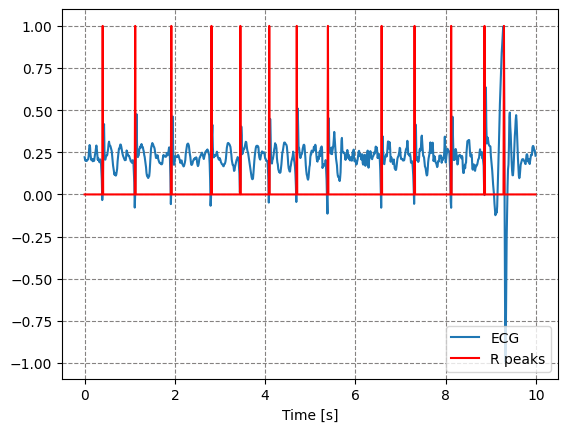

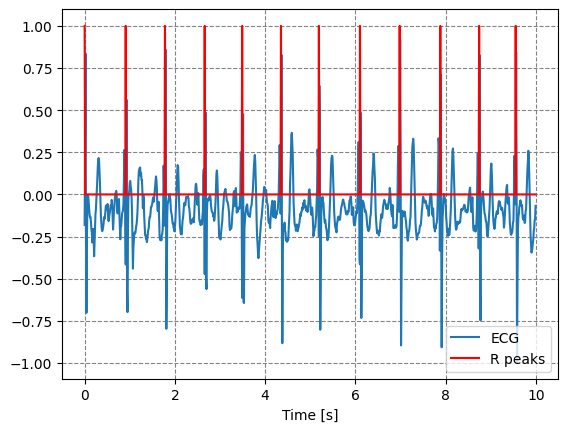

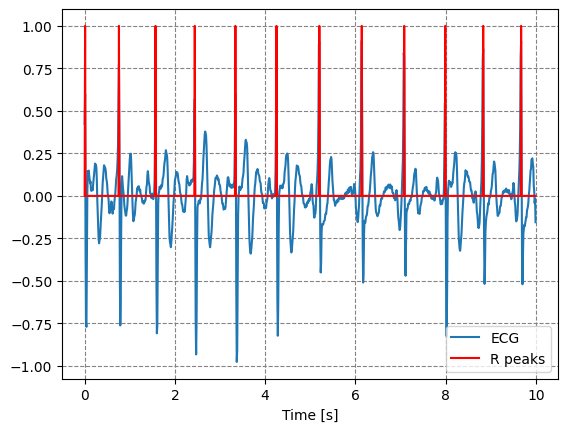

In [7]:
x_train = np.expand_dims(x_train, 2)
y_train = np.expand_dims(y_train, 2)

x_test = np.expand_dims(x_test, 2)
y_test = np.expand_dims(y_test, 2)

x_val = np.expand_dims(x_val, 2)
y_val = np.expand_dims(y_val, 2)

plot_ecg(x_train[100].flatten(), y_train[100].flatten(), 100)
plot_ecg(x_test[-1].flatten(), y_test[-1].flatten(), 100)
plot_ecg(x_val[-1].flatten(), y_val[-1].flatten(), 100)

In [8]:
batch_size = 50
input_dim = 32
seq_length = 1000
num_layers = 2
num_heads = 4
dim_feedforward = 32
dropout = 0.2

model = SimpleTransformerModel(input_dim, seq_length, num_layers, num_heads, dim_feedforward, dropout)

Training will be performed with: cuda:0


e:\anaconda3\envs\torch\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


100%|█████████▉| 237/238 [02:04<00:00,  3.05it/s]

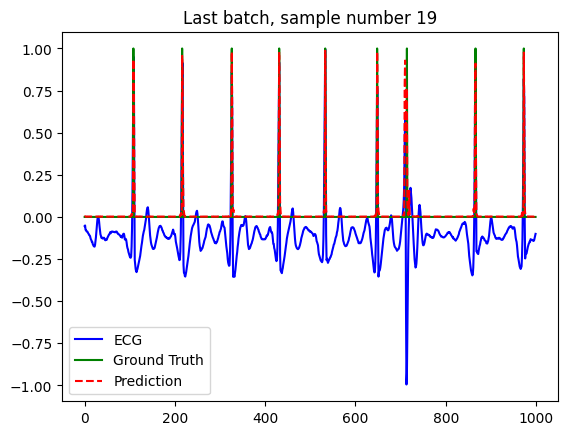

100%|██████████| 238/238 [02:05<00:00,  1.90it/s]



Train Loss: 0.0790
Train Weighted Accuracy: 0.94126
Train F1 Score: 0.53232
Train TPR: 0.90159
Train FPR: 0.01908
Train TNR: 0.98092
Train FNR: 0.09841



100%|██████████| 40/40 [00:03<00:00, 10.09it/s]



Validation Loss: 0.0754
Validation Weighted Accuracy: 0.94931
Validation F1 Score: 0.52886
Validation TPR: 0.91862
Validation FPR: 0.02000
Validation TNR: 0.98000
Validation FNR: 0.08138

====Epoch [2/10]====


100%|█████████▉| 237/238 [02:12<00:00,  1.81it/s]

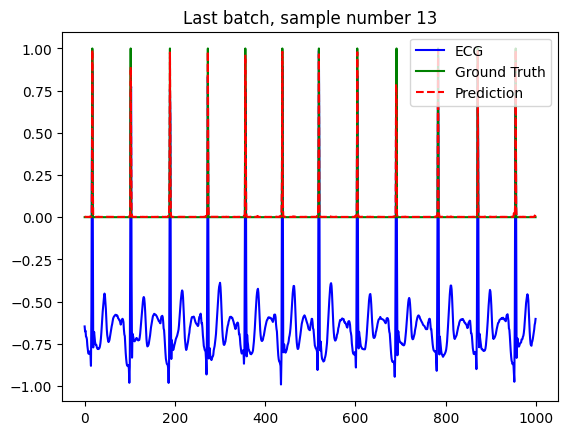

100%|██████████| 238/238 [02:12<00:00,  1.79it/s]



Train Loss: 0.0767
Train Weighted Accuracy: 0.94384
Train F1 Score: 0.53994
Train TPR: 0.90630
Train FPR: 0.01863
Train TNR: 0.98137
Train FNR: 0.09370



100%|██████████| 40/40 [00:03<00:00, 10.10it/s]



Validation Loss: 0.0734
Validation Weighted Accuracy: 0.94908
Validation F1 Score: 0.54144
Validation TPR: 0.91707
Validation FPR: 0.01891
Validation TNR: 0.98109
Validation FNR: 0.08293

====Epoch [3/10]====


100%|█████████▉| 237/238 [02:11<00:00,  1.81it/s]

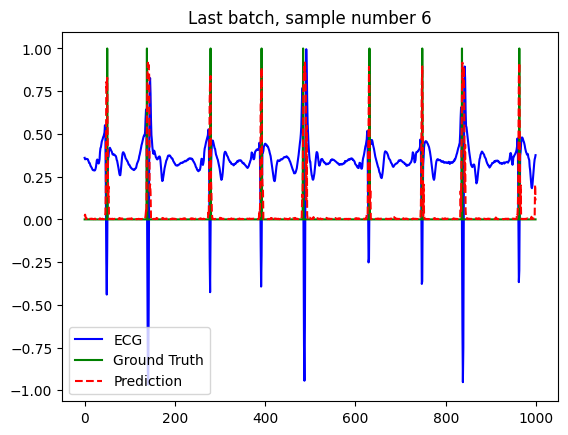

100%|██████████| 238/238 [02:12<00:00,  1.80it/s]



Train Loss: 0.0748
Train Weighted Accuracy: 0.94592
Train F1 Score: 0.54813
Train TPR: 0.90995
Train FPR: 0.01811
Train TNR: 0.98189
Train FNR: 0.09005



100%|██████████| 40/40 [00:03<00:00, 10.25it/s]



Validation Loss: 0.0716
Validation Weighted Accuracy: 0.94875
Validation F1 Score: 0.55759
Validation TPR: 0.91508
Validation FPR: 0.01758
Validation TNR: 0.98242
Validation FNR: 0.08492

====Epoch [4/10]====


100%|█████████▉| 237/238 [02:11<00:00,  1.81it/s]

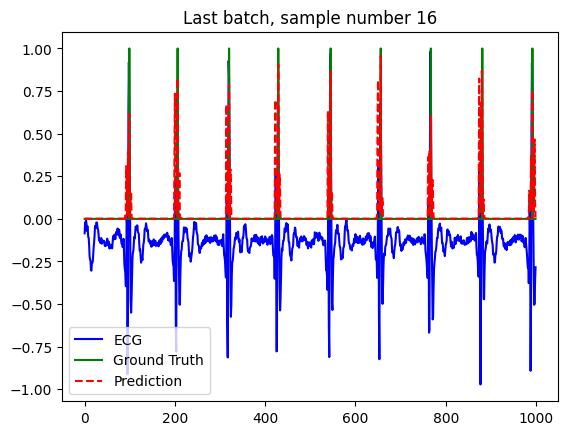

100%|██████████| 238/238 [02:12<00:00,  1.80it/s]



Train Loss: 0.0729
Train Weighted Accuracy: 0.94797
Train F1 Score: 0.55514
Train TPR: 0.91364
Train FPR: 0.01769
Train TNR: 0.98231
Train FNR: 0.08636



100%|██████████| 40/40 [00:03<00:00, 10.28it/s]



Validation Loss: 0.0700
Validation Weighted Accuracy: 0.95030
Validation F1 Score: 0.56346
Validation TPR: 0.91782
Validation FPR: 0.01723
Validation TNR: 0.98277
Validation FNR: 0.08218

====Epoch [5/10]====


100%|█████████▉| 237/238 [02:11<00:00,  1.81it/s]

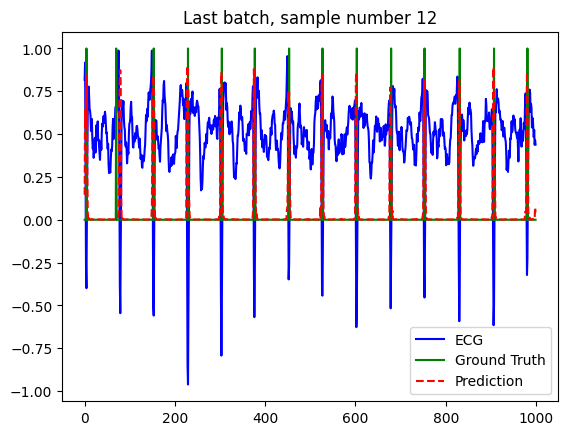

100%|██████████| 238/238 [02:12<00:00,  1.80it/s]



Train Loss: 0.0713
Train Weighted Accuracy: 0.94912
Train F1 Score: 0.56172
Train TPR: 0.91551
Train FPR: 0.01726
Train TNR: 0.98274
Train FNR: 0.08449



100%|██████████| 40/40 [00:03<00:00, 10.22it/s]



Validation Loss: 0.0686
Validation Weighted Accuracy: 0.95253
Validation F1 Score: 0.56810
Validation TPR: 0.92208
Validation FPR: 0.01703
Validation TNR: 0.98297
Validation FNR: 0.07792

====Epoch [6/10]====


 25%|██▌       | 60/238 [00:34<01:40,  1.76it/s]


KeyboardInterrupt: 

In [10]:
model.train_model(x_train=x_train, y_train=y_train, epochs=10, batch_size=batch_size, x_val=x_val, y_val=y_val) # 20 epok w sumie